# Nombre: Felipe Morales

En esta tarea vas a experimentar con diferentes funciones de activación y su rol en el aprendizaje de redes neuronales. Lo primero que haremos es importar los paquetes importantes para nuestro notebook e inicializar el gpu. Asegúrate que tu notebook se ejecuta sobre un GPU. Si es así, al ejecutar la siguiente celda debería salirte el mensaje "cuda".

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


A continuación hay un conjunto de funciones que puedes usar para hacer tus experimentos. Los detalles de cada función están como comentario antes del código de la función.

In [ ]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred = model(x) #Feed the network with data
        
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred= model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, test_loader, name):
  
  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  #Fijar el entrenamiento en 20 épocas siempre
  EPOCHS = 20

  best_valid_acc = float('-inf')

  train_loss_list = [] #
  valid_loss_list = [] #

  for epoch in range(EPOCHS):
    
    start_time = time.time()

    #Train + validation cycles  
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(network, test_loader, criterion, device)
    
    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_list.append(float(train_loss)) #
    valid_loss_list.append(float(valid_loss)) #
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')
  return train_loss_list, valid_loss_list #

Para nuestros experimentos usaremos el dataset FashionMNIST, que consta de imágenes en escala de grises de 28x28 píxeles que representan prendas de ropa clasificadas en 10 clases. Inicializamos los hiperparámetros y cargamos los conjuntos de datos de entrenamiento y prueba. También se crean los dataloaders correspondientes.

In [ ]:
# Hyper-parameters 
input_size = 784
num_classes = 10
batch_size_train = 1000
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate=0.01

# MNIST dataset 
train_dataset = torchvision.datasets.FashionMNIST(root='data', 
                    train=True, 
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]),  
                    download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=False)

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Inspeccionamos algunas muestras del conjunto de datos de prueba

Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


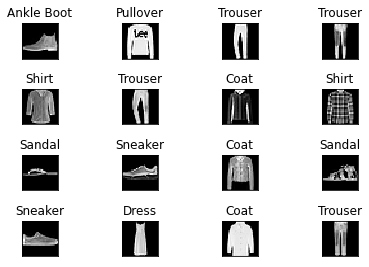

In [ ]:
examples = enumerate(test_loader) #Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) #Obtenemos el siguiente batch
print('Numero de batch: {}'.format(batchId))
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

#Mostramos los primeros 6 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title(class_names[exampleTargets[i]])
  plt.xticks([])
  plt.yticks([])

# Parte 1 - Creación de red neuronal
Crea una arquitectura de red neuronal (MLP - multilayer perceptron) que reciba datos de 784 dimensiones (recuerda que las imágenes del experimento son de 28x28 = 784 píxeles) y tenga 10 neuronas de salida. Para esta primera red usa la función sigmoide como función de activación en todas las capas ocultas y la función softmax en la capa de salida (recuerda que si usas nn.CrossEntropyLoss, no necesitas aplicar ninguna función adicional a la última capa de la red).

In [ ]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetSigmoid(nn.Module):
  def __init__(self):
    super(NetSigmoid, self).__init__()

    # Modelo 1
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 64)
    self.fc4 = nn.Linear(64, 10)

    # Modelo 2
    #self.fc1 = nn.Linear(784, 5)
    #self.fc2 = nn.Linear(5, 10)
    
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)

    # Modelo 1
    h_1 = F.sigmoid(self.fc1(x))
    h_2 = F.sigmoid(self.fc2(h_1))
    h_3 = F.sigmoid(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    # Modelo 2
    #h_1 = F.sigmoid(self.fc1(x))
    #y_pred = self.fc2(h_1)
    return y_pred


Para ejecutar el entrenamiento de tu primer modelo, ejecuta la siguiente celda y debería reportarte el accuracy de prueba de este primer experimento. Cuánto obtienes de accuracy de test?

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetSigmoid() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
sigmoid_train_loss, sigmoid_valid_loss = train_complete(network, optimizer, train_loader, test_loader, 'sigmoid') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 1.659 | Train Acc: 33.92%
	 Val. Loss: 1.073 |  Val. Acc: 55.89%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.829 | Train Acc: 66.46%
	 Val. Loss: 0.678 |  Val. Acc: 75.45%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.573 | Train Acc: 79.06%
	 Val. Loss: 0.514 |  Val. Acc: 81.08%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.460 | Train Acc: 83.72%
	 Val. Loss: 0.480 |  Val. Acc: 83.23%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.421 | Train Acc: 85.35%
	 Val. Loss: 0.452 |  Val. Acc: 84.42%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.395 | Train Acc: 86.16%
	 Val. Loss: 0.418 |  Val. Acc: 85.53%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.369 | Train Acc: 86.88%
	 Val. Loss: 0.412 |  Val. Acc: 85.35%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.362 | Train Acc: 87.25%
	 Val. Loss: 0.406 |  Val. Acc: 86.04%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.351 | Train Acc: 87.50%
	 Val. Loss: 0.399 |  Val. Acc: 85.85%
Epoch: 10 | Epoch Time: 

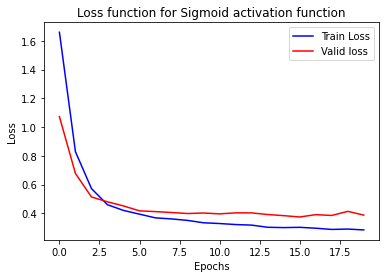

In [ ]:
plt.figure()
plt.plot(sigmoid_train_loss, color='b', label='Train Loss')
plt.plot(sigmoid_valid_loss, color='r', label='Valid loss')
plt.title('Loss function for Sigmoid activation function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

La función de activación sigmoide viene dada por $f(x) = \frac{1}{1+exp(-x)}$. 

Esta función esta acotada superior e inferiormente. Es diferenciable y $f'(x) = f(x)(1- f(x))$. A partir de $f'(x)$ es posible notar que para $x$ con valores, por ejemplo muy grandes, el gradiente se va a cero por lo que se ve comprometido el proceso de back propagation. Esto se conoce como "vanishing gradients".

Para los datos que utilizamos, si en algún momento este $x$ corresponde a un valor muy elevado, entonces la red no estaría actualizando sus parámetros y no estaría aprendiendo.

Con el modelo 1 se alcanza un test Loss: 0.375 y un mejor test acc: 87.08%

Con el modelo 2 se alcanza un test Loss: 0.556 y un Mejor test acc: 82.11%

# Parte 2
En esta parte vas a comparar el accuracy de test de la primera red que creaste (con función de activación sigmoide) y los accuracys obtenidos usando otras funciones de activación. Para lograr esto debes hacer lo siguiente:



*   Implementa exactamente la misma arquitectura que tu primera red, pero ahora vas a usar las siguientes funciones de activación: Leaky Relu, Mish, Elu y Silu. Implementa una clase por cada función de activación, en donde la red neuronal use la misma función de activación en las capas ocultas. Asegúrate que la arquitectura es la misma y que lo único que cambia entre las distintas redes es la función de activación de las capas ocultas.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre. 
*   Registra los mejores accuracys de test de cada red neuronal.
*   Discute los resultados ontenidos. Puedes tratar de responder a estas preguntas:
    * Qué función de activación dio el mejor accuracy de test?
    * Porqué crees que, ante las mismas condiciones, hay funciones de activación que funcionan mejor que otras?
    * Averigua cómo funcionan cada una de las funciones de activación usadas en la tarea. Es posible hacer algún razonamiento sobre el comportamiento de cada función y que eso permita explicar los resultados de tu tarea?

# Leaky Relu

In [ ]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetRelu(nn.Module):
  def __init__(self):
    super(NetRelu, self).__init__()
    # Modelo 1
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 64)
    self.fc4 = nn.Linear(64, 10)

    # Modelo 2
    #self.fc1 = nn.Linear(784, 5)
    #self.fc2 = nn.Linear(5, 10)
    
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    m = nn.LeakyReLU(0.1)

    # Modelo 1
    h_1 = m(self.fc1(x))
    h_2 = m(self.fc2(h_1))
    h_3 = m(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    # Modelo 2
    #h_1 = m(self.fc1(x))
    #y_pred = m(self.fc2(h_1))
    return y_pred
  

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetRelu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
relu_train_loss, relu_valid_loss = train_complete(network, optimizer, train_loader, test_loader, 'leaky relu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.631 | Train Acc: 61.71%
	 Val. Loss: 0.612 |  Val. Acc: 77.71%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.494 | Train Acc: 81.76%
	 Val. Loss: 0.469 |  Val. Acc: 82.88%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.416 | Train Acc: 84.73%
	 Val. Loss: 0.444 |  Val. Acc: 84.34%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.366 | Train Acc: 86.51%
	 Val. Loss: 0.413 |  Val. Acc: 84.60%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.348 | Train Acc: 87.33%
	 Val. Loss: 0.393 |  Val. Acc: 86.04%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.339 | Train Acc: 87.52%
	 Val. Loss: 0.394 |  Val. Acc: 86.02%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.313 | Train Acc: 88.46%
	 Val. Loss: 0.372 |  Val. Acc: 86.69%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.301 | Train Acc: 88.78%
	 Val. Loss: 0.380 |  Val. Acc: 86.63%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.291 | Train Acc: 89.12%
	 Val. Loss: 0.366 |  Val. Acc: 86.70%
Epoch: 10 | Epoch Time

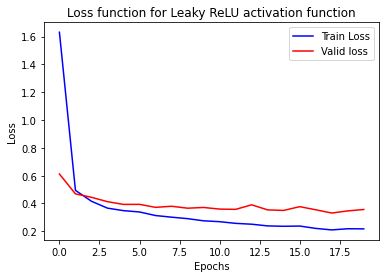

In [ ]:
plt.figure()
plt.plot(relu_train_loss, color='b', label='Train Loss')
plt.plot(relu_valid_loss, color='r', label='Valid loss')
plt.title('Loss function for Leaky ReLU activation function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

Leaky Rectified Linear Unit es una función de activación que viene dada por $f(x) = x$ para $x > 0$ y $f(x) = α*x$ para $x ≤ 0$. El parámetro α debe ser mayor a cero y suele ser $α = 0.01$.

Esta función viene a hacer frente a un problema de la función ReLU para la cual, al momento de calcular los gradientes, ReLU no aprende cuando tenemos muchos valores negativos pues $f'(x)$ es 0 para $x < 0$, es decir, quedan neuronas sin utilizar. Por otra parte, Leaky ReLU se tiene que $f'(x) = α$. Con esto tenemos al menos un valor que permite tener un gradiente. Si la comparamos con la función sigmoide esta obtiene mejores resultados pues presenta una monotonia que permite hacer frente al problema de "vanishing gradients". Ahora, para nuestros datos, si $x$ tiene un valor muy elevado entonces es posible tener un gradiente que permita mejorar el proceso de aprendizaje.

Con el modelo 1 se alcanza un test Loss: 0.331 y el mejor test acc: 88.57%

Con el modelo 2 se alcanza un test Loss: 0.490 y un Mejor test acc: 83.08%

# Mish

In [ ]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetMish(nn.Module):
  def __init__(self):
    super(NetMish, self).__init__()

    # Modelo 1
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 64)
    self.fc4 = nn.Linear(64, 10)

    # Modelo 2
    #self.fc1 = nn.Linear(784, 5)
    #self.fc2 = nn.Linear(5, 10)
    
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    m = nn.Mish()

    # Modelo 1
    h_1 = m(self.fc1(x))
    h_2 = m(self.fc2(h_1))
    h_3 = m(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    # Mdelo 2
    #h_1 = m(self.fc1(x))
    #y_pred = self.fc2(h_1)
    return y_pred
  

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetMish() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
mish_train_loss, mish_valid_loss = train_complete(network, optimizer, train_loader, test_loader, 'mish') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.326 | Train Acc: 64.81%
	 Val. Loss: 0.534 |  Val. Acc: 80.39%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.426 | Train Acc: 84.48%
	 Val. Loss: 0.419 |  Val. Acc: 85.18%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.365 | Train Acc: 86.63%
	 Val. Loss: 0.404 |  Val. Acc: 86.02%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.333 | Train Acc: 87.72%
	 Val. Loss: 0.393 |  Val. Acc: 85.62%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.305 | Train Acc: 88.82%
	 Val. Loss: 0.364 |  Val. Acc: 87.15%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.295 | Train Acc: 89.09%
	 Val. Loss: 0.369 |  Val. Acc: 87.14%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.280 | Train Acc: 89.50%
	 Val. Loss: 0.361 |  Val. Acc: 87.45%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.273 | Train Acc: 89.93%
	 Val. Loss: 0.356 |  Val. Acc: 87.50%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.253 | Train Acc: 90.60%
	 Val. Loss: 0.360 |  Val. Acc: 87.49%
Epoch: 10 | Epoch Time:

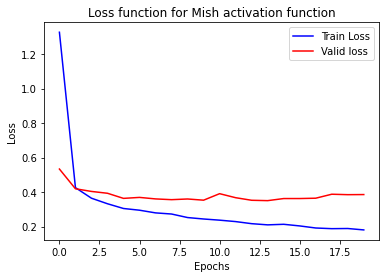

In [ ]:
plt.figure()
plt.plot(mish_train_loss, color='b', label='Train Loss')
plt.plot(mish_valid_loss, color='r', label='Valid loss')
plt.title('Loss function for Mish activation function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

Mish es una función de activación que viene definida por $f(x) = x * tanh(softplus(x))$ donde $softplus(x) = ln(1 + exp(x))$.

Algunas carateristicas de esta funcion es que está acotada inferiormente como otras funciones de activación como sigmoid, ReLU, ELU y SiLU. Es continuamente diferenciable y es no monotona. Al igual que Leaky ReLU solventa el problema de tener neuronas que no se activen debido a que $f'(x) != 0$ para valores negativos permitiendo tener un mejor proceso de actualización en backward propagation. Sin embargo esta función es costosa computacionalmente.

En cuanto a la función sigmoide se tiene el mismo análisis con Leaky ReLU, es decir, Mish obtiene mejores resultados.

Con el modelo 1 se alcanza un test Loss: 0.365 y un Mejor test acc: 88.34%

Con el modelo 2 se alcanza un test Loss: 0.495 y un Mejor test acc: 83.03%

# ELU

In [ ]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetElu(nn.Module):
  def __init__(self):
    super(NetElu, self).__init__()

    # Modelo 1
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 64)
    self.fc4 = nn.Linear(64, 10)

    # Modelo 2
    #self.fc1 = nn.Linear(784, 5)
    #self.fc2 = nn.Linear(5, 10)
    
    
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    m = nn.ELU()

    # Modelo 1
    h_1 = m(self.fc1(x))
    h_2 = m(self.fc2(h_1))
    h_3 = m(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    # Modelo 2
    #h_1 = m(self.fc1(x))
    #y_pred = self.fc2(h_1)
    return y_pred
  

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetElu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
elu_train_loss, elu_valid_loss = train_complete(network, optimizer, train_loader, test_loader, 'elu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 1.706 | Train Acc: 61.48%
	 Val. Loss: 0.619 |  Val. Acc: 75.20%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.523 | Train Acc: 80.20%
	 Val. Loss: 0.493 |  Val. Acc: 81.48%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.431 | Train Acc: 84.29%
	 Val. Loss: 0.461 |  Val. Acc: 83.37%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.388 | Train Acc: 85.64%
	 Val. Loss: 0.408 |  Val. Acc: 85.32%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.354 | Train Acc: 86.79%
	 Val. Loss: 0.407 |  Val. Acc: 85.67%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.336 | Train Acc: 87.55%
	 Val. Loss: 0.375 |  Val. Acc: 86.33%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.304 | Train Acc: 88.71%
	 Val. Loss: 0.373 |  Val. Acc: 86.90%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.307 | Train Acc: 88.65%
	 Val. Loss: 0.367 |  Val. Acc: 86.99%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.278 | Train Acc: 89.70%
	 Val. Loss: 0.361 |  Val. Acc: 87.33%
Epoch: 10 | Epoch T

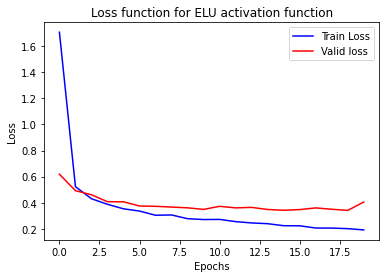

In [ ]:
plt.figure()
plt.plot(elu_train_loss, color='b', label='Train Loss')
plt.plot(elu_valid_loss, color='r', label='Valid loss')
plt.title('Loss function for ELU activation function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

Exponential Linear Unit (ELU) es una función de activación la cual se define como $f(x) = x$ para $x > 0$ y $f(x) = α * (exp(x) - 1)$ para $x ≤ 0$.

Algunas caraterísticas de esta función es que es continuamente diferenciable. Al igual que las funciones anteriores produce valores negativos que permite un mejor operación en backward propagation. A diferencia de Leaky ReLU, ante valores negativos, esta función esta acotada por lo que se impide un desbalance del modelo respecto a los distintos inputs. Sin embargo esta función depende de un parametro $α$ y es costosa computacionalmente.

Se obtiene mejores resultados si comparamos con la función sigmoid por las razones mencionadas anteriormente.

Con el modelo 1 se alcanza un test loss: 0.341 y un mejor test acc: 88.94%

Con el modelo 2 se alcanza un test loss: 0.492 y un mejor test acc: 82.80%

# SiLU

In [ ]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetSilu(nn.Module):
  def __init__(self):
    super(NetSilu, self).__init__()

    # Modelo 1
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 64)
    self.fc4 = nn.Linear(64, 10)

    # Modelo 2
    #self.fc1 = nn.Linear(784, 5)
    #self.fc2 = nn.Linear(5, 10)
    
    
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    m = nn.SiLU()

    # Modelo 1
    h_1 = m(self.fc1(x))
    h_2 = m(self.fc2(h_1))
    h_3 = m(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    # Modelo 2
    #h_1 = m(self.fc1(x))
    #y_pred = self.fc2(h_1)
    return y_pred
  

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetSilu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
silu_train_loss, silu_valid_loss = train_complete(network, optimizer, train_loader, test_loader, 'silu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.247 | Train Acc: 66.99%
	 Val. Loss: 0.507 |  Val. Acc: 81.94%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.418 | Train Acc: 84.71%
	 Val. Loss: 0.399 |  Val. Acc: 85.69%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.363 | Train Acc: 86.72%
	 Val. Loss: 0.387 |  Val. Acc: 86.21%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.332 | Train Acc: 87.68%
	 Val. Loss: 0.385 |  Val. Acc: 86.07%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.309 | Train Acc: 88.57%
	 Val. Loss: 0.356 |  Val. Acc: 87.24%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.295 | Train Acc: 89.07%
	 Val. Loss: 0.345 |  Val. Acc: 87.83%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.274 | Train Acc: 89.74%
	 Val. Loss: 0.348 |  Val. Acc: 87.66%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.265 | Train Acc: 90.29%
	 Val. Loss: 0.342 |  Val. Acc: 87.88%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.252 | Train Acc: 90.48%
	 Val. Loss: 0.359 |  Val. Acc: 87.41%
Epoch: 10 | Epoch T

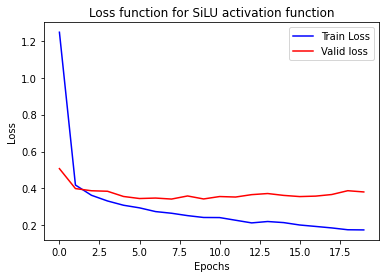

In [ ]:
plt.figure()
plt.plot(silu_train_loss, color='b', label='Train Loss')
plt.plot(silu_valid_loss, color='r', label='Valid loss')
plt.title('Loss function for SiLU activation function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Comentarios

Sigmoid Linear Unit (SiLU) es una función de activación dada por $f(x) = x * σ(x)$ donde $σ(x)$ corresponde al logistic sigmoid.

Esta función, al igual que Mish, no es en estricto rigor monótona. También tiene valores negativos que mejora la operacion de backward propagation. El hecho de no ser monótona implica que el resultado puede ir bajando a medida que el input aumenta. Al igual que las otras funciones es costosa computacionalmente.

Se obtiene mejores resultados si comparamos con la función sigmoid por las razones mencionadas anteriormente.

Con el modelo 1 se alcanza un test Loss: 0.356 y un mejor test acc: 88.51%

Con el modelo 2 se alcanza un test Loss: 0.508 y un mejor test acc: 82.82%

# Resultados

## Modelo 1
| Función de activación | Test Loss | Mejor test accuracy |
| :--- | :---: | ---: |
| Sigmoid | 0.375 | 87.08% |
| Leaky ReLU | 0.331 | 88.57% |
| Mish | 0.365 | 88.64% |
| ELU | 0.341 | 88.94% |
| SiLU | 0.356 | 88.51% |

## Modelo 2
| Función de activación | Test Loss | Mejor test accuracy |
| :--- | :---: | ---: |
| Sigmoid | 0.556 | 82.11% |
| Leaky ReLU | 0.490 | 83.08% |
| Mish | 0.495 | 83.03% |
| ELU | 0.492 | 82.80% |
| SiLU | 0.508 | 82.82% |

Hechos estos experimentos se hacen algunas observaciones, estas son que los mejores resultados se obtuvieron con la función de activación ELU para el modelo 1 y la función Mish para el modelo 2, además todas estas funciones superaron el test accuracy de aquel modelo que presenta la funcion sigmoid.

Para el modelo 2 nos apoyamos de forma más significativa en las funciones de activación dado que la capacidad de aprendizaje de la red es menor. Aquí Leaky ReLu y Mish obtuvieron los mejores resultados mientras que, para el modelo 1, Mish y ELU obtuvieron los mejores resultados.

Existen estudios externos que demuestran que Mish obtiene los mejores resultados sin embargo la función ReLU es la que se usa generalmente y, si los resultados no son los deseables, se puede probar con otras para hacer frente al problema de "vanishing gradients".